# **Group Assignment** - Bike Sharing

- `instant`: record index
- `dteday` : date
- `season` : season (1:springer, 2:summer, 3:fall, 4:winter)
- `yr` : year (0: 2011, 1:2012)
- `mnth` : month ( 1 to 12)
- `hr` : hour (0 to 23)
- `holiday` : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday` : day of the week
- `workingday` : if day is neither weekend nor holiday is 1, otherwise is 0.
+ `weathersit` : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp` : Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

## PART I: Exploratory Data Analysis

In [65]:
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

import pandas as pd
import numpy as np
import joblib

In [33]:
data = pd.read_csv("bike-sharing_hourly.csv")
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
# Count the number of nulls in each column
null_counts = data.isnull().sum()

# Display the number of nulls in each column
print("Number of Nulls in Each Column:")
print(null_counts)

Number of Nulls in Each Column:
instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


We don't need to clean the nulls.

We can see that 'working day' is binary.
'yr' is also binary.

In [34]:
# Create new 'day' variable from 'dteday'
data['day'] = data['dteday'].apply(lambda x: str(x)[-2:])

In [35]:
# Then drop the 'dteday' variable - this information is all included in other variables now
data = data.drop(["dteday"],axis=1)

**Our target variable will be "cnt", as the customer is interested in the total.. Therefore we will also drop "casual" and "registered" in X, to avoid any overlapping data.
However, we will also be dropping "instant" (because it does not add anything to the information) and "yr" because it will indicate much regarding trends, as opposed to "mnth" or "season".**

In [36]:
data = data.drop(["casual","registered","instant","yr"],axis=1)

**It is time to begin taking a look at the data through visualizations.**

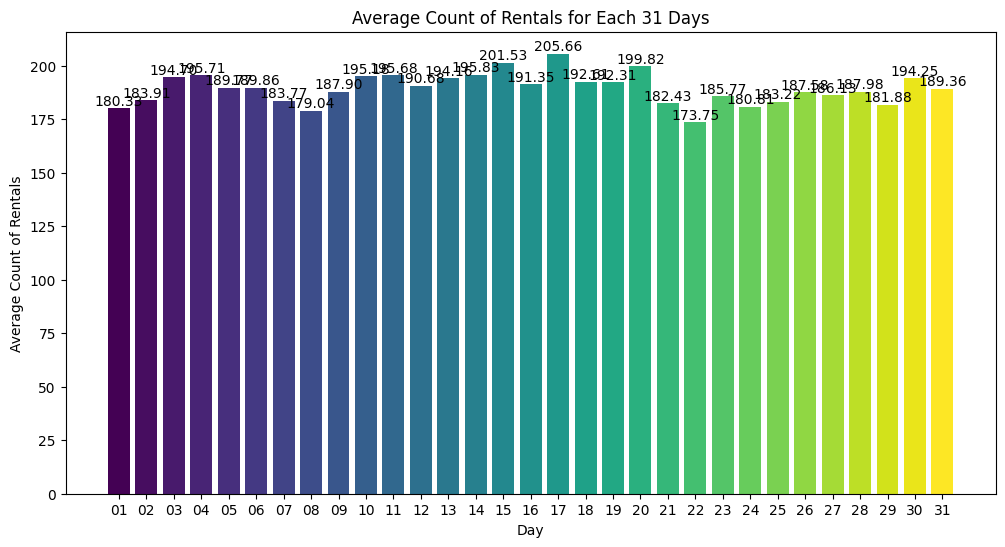

In [9]:
# Group by 'day' and calculate the average counts
day_avg_counts = data.groupby('day')['cnt'].mean()

# Generate different colors for each bar
colors = plt.cm.viridis(np.linspace(0, 1, len(day_avg_counts)))

# Plot the bar chart with different colors
plt.figure(figsize=(12, 6))
bars = plt.bar(day_avg_counts.index, day_avg_counts, color=colors)

# Annotate each bar with the exact number
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.title('Average Count of Rentals for Each 31 Days')
plt.xlabel('Day')
plt.ylabel('Average Count of Rentals')
plt.show()

Using the new column 'Day' we created earlier, we created a bar chart to show the average of rentals depending on which day of the month it was (over the two years).
From this chart, we can see pull a few insights: 
- People rent the bikes the most during the middle of the month (~from day 10 to day 20)
- The least popular day is the 22nd
- The most popular day is the 17th

Below is the same chart but using plotly express for easier Streamlit inclusion.

In [10]:
# Group by 'day' and calculate the average counts
day_avg_counts = data.groupby('day')['cnt'].mean().reset_index()

# Create the bar chart using Plotly Express
fig5 = px.bar(day_avg_counts, x='day', y='cnt', 
             title='Mean Rentals by Day of the Month',
             labels={'cnt': 'Mean Rentals', 'day': 'Day of Month'},
             color='cnt',  
             color_continuous_scale='viridis',  
             width=800, height=500) 
fig5.show()

Text(0, 0.5, 'Count of Rentals')

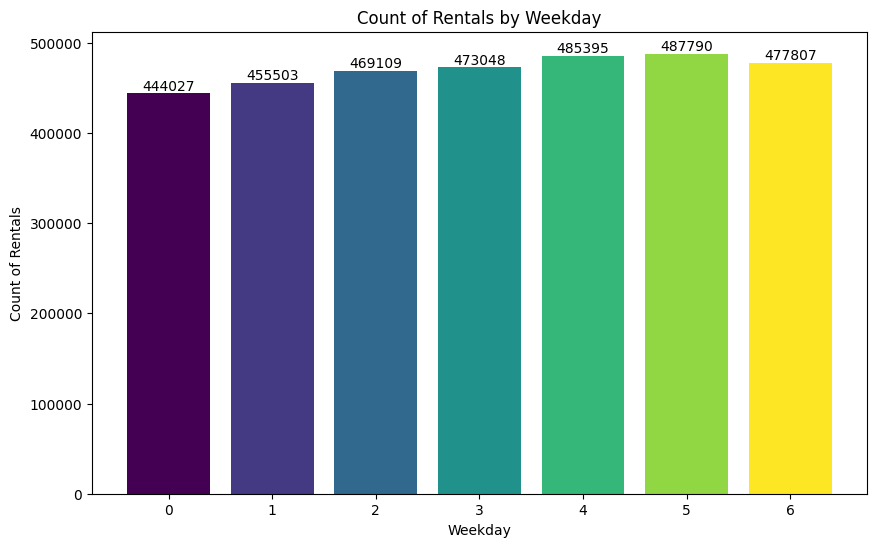

In [11]:
# Group by 'weekday' and sum the counts
weekday_counts = data.groupby('weekday')['cnt'].sum()

# Generate different colors for each bar
colors = plt.cm.viridis(np.linspace(0, 1, len(weekday_counts)))

# Plot the bar chart with annotations and different colors
plt.figure(figsize=(10, 6))
bars = plt.bar(weekday_counts.index, weekday_counts, color=colors)

# Annotate each bar with the exact number
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

plt.title('Count of Rentals by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Count of Rentals')


**Following the logic for the previous chart, we also did a bar chart to count the total for the days of the week (Day 0 represents Sundays).
It's interesting to note that the total count gradually increases as the week continues, and then, strangely, goes back down on Saturday (which is a day where we would expect more people to rent). From this, we can deduce that a large number of customers use the bikes to go to work (so during the week). There could potentially be some interesting promotional campaigns made around this insight. For example, we could recommend to create a promotional campaign to encourage people to rent more during the week-end, for example: "First 3 minutes are free on Sundays" (Sundays because it is the least popular day)**.

Below is the same chart but using plotly express for easier Streamlit inclusion.

In [13]:
fig1 = px.bar(weekday_counts, x='weekday', y='cnt', 
            title='Count of Rentals by Day of Week',
            labels={'cnt': 'Count of Rentals', 'weekday': 'Day of Week'},
            color='cnt', 
            color_continuous_scale='viridis',  
            width=800, height=500)
fig1.update_layout(
        xaxis = dict(
            tickmode = 'array',
            tickvals = [0,1,2,3,4,5,6],
            ticktext = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
        ))

# Show the chart
fig1.show()

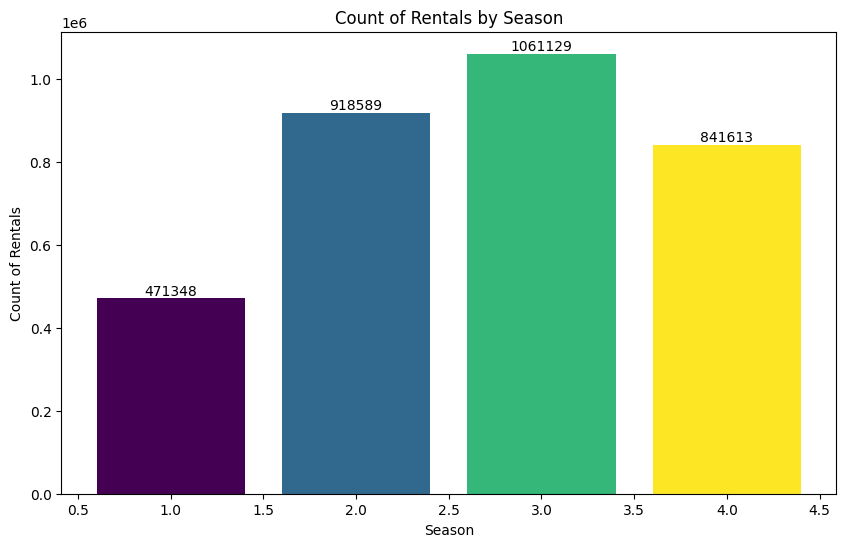

In [13]:

# Group by 'season' and sum the counts
season_counts = data.groupby('season')['cnt'].sum()

# Generate different colors for each bar
colors = plt.cm.viridis(np.linspace(0, 1, len(season_counts)))

# Plot the bar chart with annotations and different colors
plt.figure(figsize=(10, 6))
bars = plt.bar(season_counts.index, season_counts, color=colors)

# Annotate each bar with the exact number
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

plt.title('Count of Rentals by Season')
plt.xlabel('Season')
plt.ylabel('Count of Rentals')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()


**This is also an interesting insight for seasonal campaigns or cost optimization decisions.
There is an evident variation in the quantity of bike rentals between the different seasons, giving easy indications to the customer on how to manage the bike fleet according to this. 
For example, the customer could deploy less / make less bikes available during Spring and Winter seasons, as that is when there have been the least rentals.. And, on the contrary, the customer could then increase the number of available bikes Summer and Fall. This would help reduce the costs of maintaining the bikes during the least popular seasons, and would increase profits when bikes are very popular, so during Summer and Fall.**

Below is the same chart but using plotly express for easier Streamlit inclusion.

In [15]:
# Group by 'season' and sum the counts
season_counts = data.groupby('season')['cnt'].sum().reset_index()

fig1 = px.bar(season_counts, 
            x='season', 
            y='cnt', 
            labels={"season": 'Season', "cnt": 'Count of Rentals'},
            title='Count of Rentals by Season',
            barmode='group',
            color='cnt',
            color_continuous_scale='viridis', 
            width=800, height=500)  
fig1.update_layout(
        xaxis = dict(
            tickmode = 'array',
            tickvals = [1,2,3,4],
            ticktext = ["Spring","Summer","Autumn","Winter"]
        ))

# Show the chart
fig1.show()


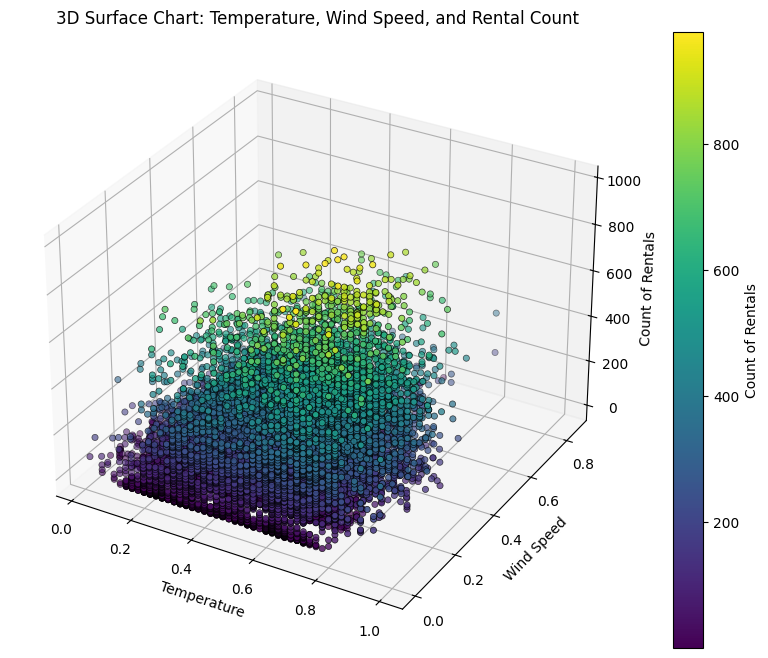

In [15]:
# Extract relevant columns
temperature = data['temp']
windspeed = data['windspeed']
count = data['cnt']

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surface = ax.scatter(temperature, windspeed, count, c=count, cmap='viridis', edgecolors='k', linewidth=0.5)

# Customize the plot
ax.set_xlabel('Temperature')
ax.set_ylabel('Wind Speed')
ax.set_zlabel('Count of Rentals')
ax.set_title('3D Surface Chart: Temperature, Wind Speed, and Rental Count')

# Add colorbar
cbar = fig.colorbar(surface)
cbar.set_label('Count of Rentals')

plt.show()


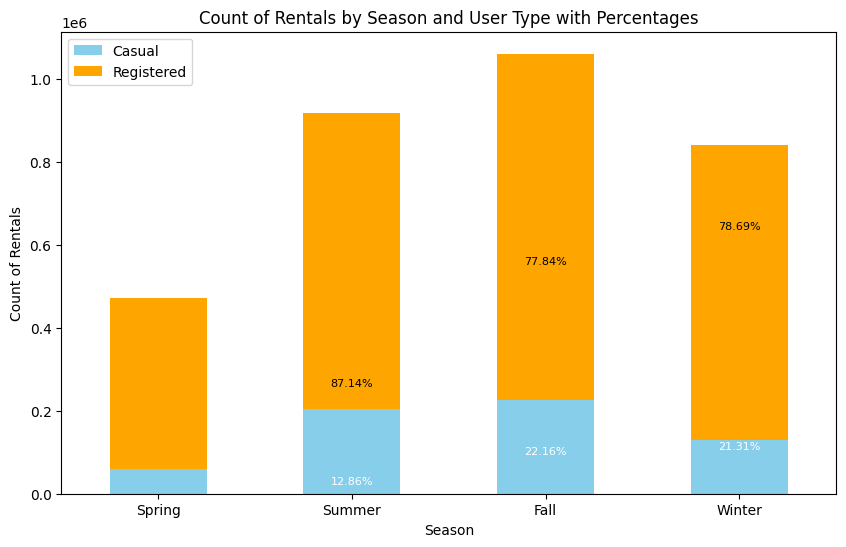

In [16]:
# Group by 'season' and sum the counts for casual and registered users
seasonal_counts = data.groupby('season')[['casual', 'registered']].sum()

# Calculate percentages of total for casual and registered
seasonal_percentages = seasonal_counts.div(seasonal_counts.sum(axis=1), axis=0) * 100

# Plot the grouped bar chart
ax = seasonal_counts.plot(kind='bar', stacked=True, color=['skyblue', 'orange'], figsize=(10, 6))

# Add percentages on each bar with two decimal places
for season in seasonal_counts.index:
    total_count = seasonal_counts.loc[season].sum()
    casual_percentage = seasonal_counts.loc[season, 'casual'] / total_count * 100
    registered_percentage = seasonal_counts.loc[season, 'registered'] / total_count * 100

    ax.annotate(f'{casual_percentage:.2f}%', (season, seasonal_counts.loc[season, 'casual'] / 2), ha='center', va='center', fontsize=8, color='white')
    ax.annotate(f'{registered_percentage:.2f}%', (season, total_count - seasonal_counts.loc[season, 'registered'] / 2), ha='center', va='center', fontsize=8, color='black')

# Customize the plot
plt.title('Count of Rentals by Season and User Type with Percentages')
plt.xlabel('Season')
plt.ylabel('Count of Rentals')
plt.xticks(ticks=range(4), labels=['Spring', 'Summer', 'Fall', 'Winter'], rotation=0)
plt.legend(['Casual', 'Registered'], loc='upper left')

plt.show()


**Here we wanted to look at how the season change really affects the users.. if for example registered users will keep renting their bike regardless of the season or weather conditions (since they are paying a subscription).. or at least if they are less sensitive to these changes affecting their choice to bike, as opposed to casual users.
We can now see that this is clearly the case. It is also strange that the distribution is the least balanced during Spring and Summer. We could recommend to add a coupon for first-time users during these seasons.**

Below is a similar chart but using plotly express for easier Streamlit inclusion.

In [51]:
# Upload original data so we have the registered and casual counts
original_data = pd.read_csv("bike-sharing_hourly.csv")

# Format the data properly so we can use it to show percentages in the stacked bar charts
season_reg = original_data.groupby('season')[['registered']].sum().reset_index()
season_reg['TYPE'] = 'Registered'
season_reg['user'] = season_reg['registered']
season_reg = season_reg.drop('registered',axis=1)

season_cas = original_data.groupby('season')[['casual']].sum().reset_index()
season_cas['TYPE'] = 'Casual'
season_cas['user'] = season_cas['casual']
season_cas = season_cas.drop('casual',axis=1)

# Combine above DFs vertically and add weight column
combine_season = (season_reg,season_cas)
total_season = pd.concat(combine_season)
total_season['weight'] = total_season['user'] / total_season.groupby(['season'])['user'].transform('sum')

fig2 = px.bar(total_season, x="season", y='weight', color='TYPE',  
            title="Share of Casual and Registered Users by Season",
            labels={'weight': 'Share', 'TYPE': 'Type of User','season':'Season'},
            color_discrete_sequence=['rebeccapurple','darkcyan'],
            width=800, height=500)
fig2.update_layout(
        xaxis = dict(
            tickmode = 'array',
            tickvals = [1,2,3,4],
            ticktext = ["Spring","Summer","Autumn","Winter"]
        ))
fig2.update_traces(texttemplate='%{value:.2f}')

# Show the chart
fig2.show()


In [18]:
# Filter data for Spring season
spring_data = original_data[original_data['season'] == 1]

# Calculate counts for casual and registered users in Spring
spring_counts = spring_data[['casual', 'registered']].sum()

# Calculate percentages of total for casual and registered
spring_percentages = spring_counts / spring_counts.sum() * 100

print("Spring Percentage Repartition:")
print(f"Casual: {spring_percentages['casual']:.2f}%")
print(f"Registered: {spring_percentages['registered']:.2f}%")


Spring Percentage Repartition:
Casual: 12.86%
Registered: 87.14%


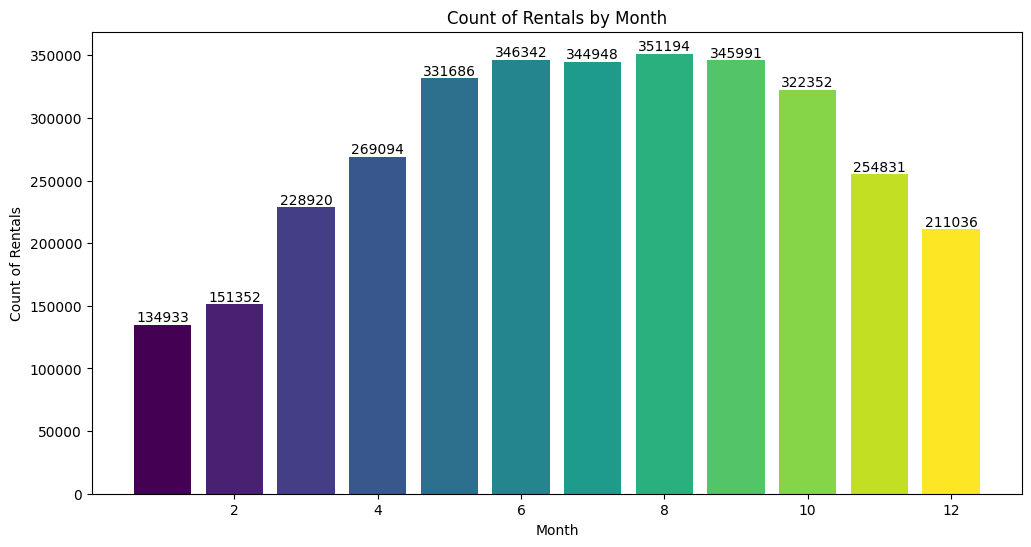

In [19]:

# Group by 'mnth' (month) and sum the counts
month_counts = data.groupby('mnth')['cnt'].sum()

# Generate different colors for each bar
colors = plt.cm.viridis(np.linspace(0, 1, len(month_counts)))

# Plot the bar chart with annotations and different colors
plt.figure(figsize=(12, 6))
bars = plt.bar(month_counts.index, month_counts, color=colors)

# Annotate each bar with the exact number
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

plt.title('Count of Rentals by Month')
plt.xlabel('Month')
plt.ylabel('Count of Rentals')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()

**This bar chart follows a pretty straightforward logic, as the months get warmer, the total amount of bike users increases.**

Below is a similar chart but using plotly express for easier Streamlit inclusion.

In [20]:
# Group by 'mnth' (month) and sum the counts
month_counts = data.groupby('mnth')['cnt'].sum().reset_index()

fig1 = px.bar(month_counts, 
            x='mnth', 
            y='cnt', 
            labels={"mnth": 'Month', "cnt": 'Count of Rentals'},
            title='Count of Rentals by Month',
            barmode='group',
            color='cnt', 
            color_continuous_scale='viridis',  
            width=800, height=500
        )
fig1.update_layout(
        xaxis = dict(
            tickmode = 'array',
            tickvals = [1,2,3,4,5,6,7,8,9,10,11,12],
            ticktext = ["January","February","March","April","May","June","July","August","September","October","November","December"]
        ))

# Show the chart
fig1.show()

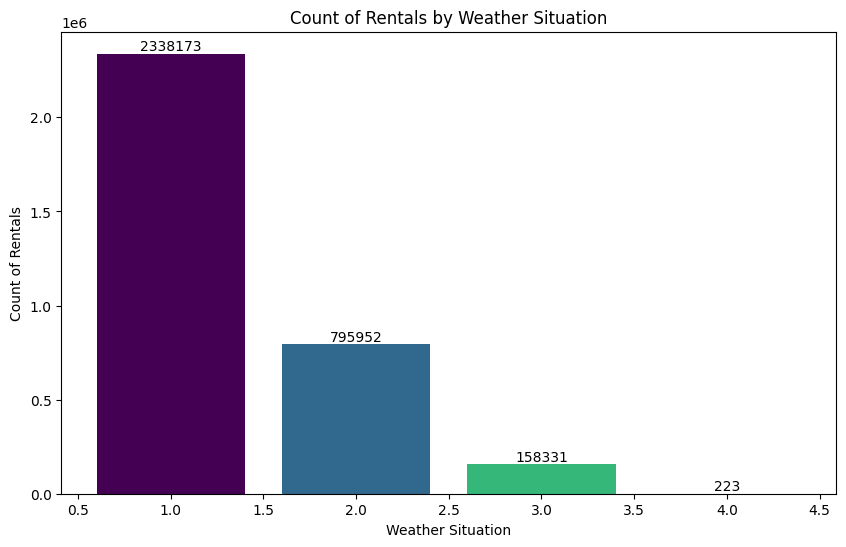

In [21]:

weather_counts = data.groupby('weathersit')['cnt'].sum()

# Generate different colors for each bar
colors = plt.cm.viridis(np.linspace(0, 1, len(weather_counts)))

# Plot the bar chart with annotations and different colors
plt.figure(figsize=(10, 6))
bars = plt.bar(weather_counts.index, weather_counts, color=colors)

# Annotate each bar with the exact number
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

plt.title('Count of Rentals by Weather Situation')
plt.xlabel('Weather Situation')
plt.ylabel('Count of Rentals')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()


**The amount of bikes rented is so low for weather conditions 3 & 4 that it might be wise to limit the capacity and availability of these bikes during those times in order to increase cost optimization and avoid spending money while leaving these bikes idle and paying employees managing them when not many people rent them.**

Below is a similar chart but using plotly express for easier Streamlit inclusion.

In [21]:
# Group by 'weathersit' and sum the counts
weather_counts = data.groupby('weathersit')['cnt'].sum().reset_index()

fig2 = px.bar(weather_counts, 
            x='cnt', 
            y='weathersit', 
            labels={"cnt": 'Count of Rentals',"weathersit": 'Weather Type'},
            title='Count of Rentals by Weather',
            orientation='h',
            barmode='group',
            color='cnt',  
            color_continuous_scale='viridis',
            width=800, height=500)
fig2.update_layout(
        yaxis = dict(
            tickmode = 'array',
            tickvals = [1,2,3,4],
            ticktext = ["Mostly Clear",
                    "Misty",
                    "Light Rain or Snow",
                    "Heavy Rain or Snow, and Thunderstorms"]
        ))

# Show the chart
fig2.show()


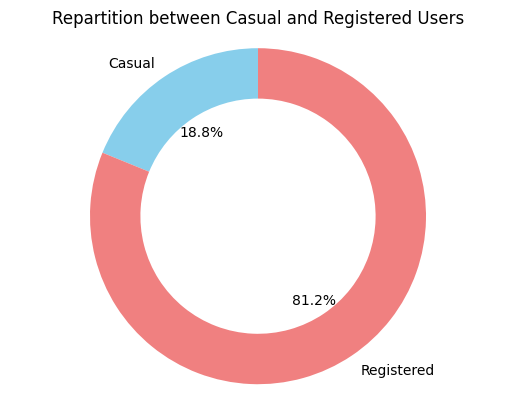

In [23]:

# Calculate the total counts for 'casual' and 'registered'
total_casual = data['casual'].sum()
total_registered = data['registered'].sum()

# Create a donut chart
labels = ['Casual', 'Registered']
sizes = [total_casual, total_registered]
colors = ['skyblue', 'lightcoral']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops=dict(width=0.3))

# Draw a circle in the center to create a donut chart
centre_circle = plt.Circle((0, 0), 0.2, color='white', linewidth=0.8)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')  
plt.title('Repartition between Casual and Registered Users')
plt.show()


**This large unbalance between the types of users could be a good indication to perhaps change the bike sharing app to a 'Freemium' type of service.. giving more options and bonuses to registered users, and so inciting more people to pay for a subscription.**

Below is a similar chart but using plotly express for easier Streamlit inclusion.

In [22]:
# Define labels and sizes for the pie chart
labels = ['Casual', 'Registered']
sizes = [original_data['casual'].sum(), original_data['registered'].sum()]
colors = ['darkcyan', 'rebeccapurple']

# Create the pie chart using Plotly Express
fig = go.Figure(data=[go.Pie(labels=labels, values=sizes, hole=0.5, textinfo='percent', marker=dict(colors=colors))])

# Set layout options
fig.update_layout(title='Share of Casual and Registered Users')

# Show the chart
fig.show()


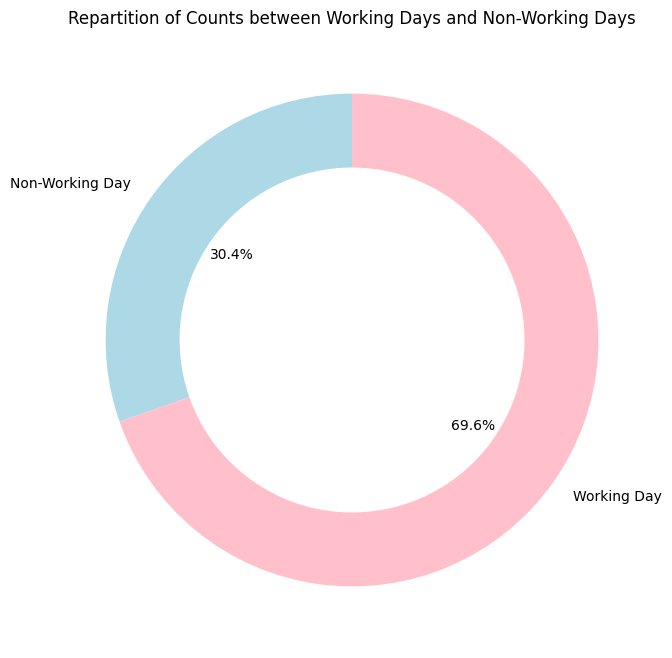

In [23]:
# Group by 'workingday' and sum the counts
workingday_counts = data.groupby('workingday')['cnt'].sum()

# Define colors
colors = ['lightblue', 'pink']

# Create a donut chart with custom colors
plt.figure(figsize=(8, 8))
plt.pie(workingday_counts, labels=['Non-Working Day', 'Working Day'], autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3), colors=colors)
plt.title('Repartition of Counts between Working Days and Non-Working Days')

# Draw a circle at the center to create a donut chart
centre_circle = plt.Circle((0, 0), 0.6, color='white', fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Show the plot
plt.show()

**Here we wanted to see the distribution between the total count of bike rentals during working days and during non-working days (including week-ends and holidays). See next chart for analysis...**

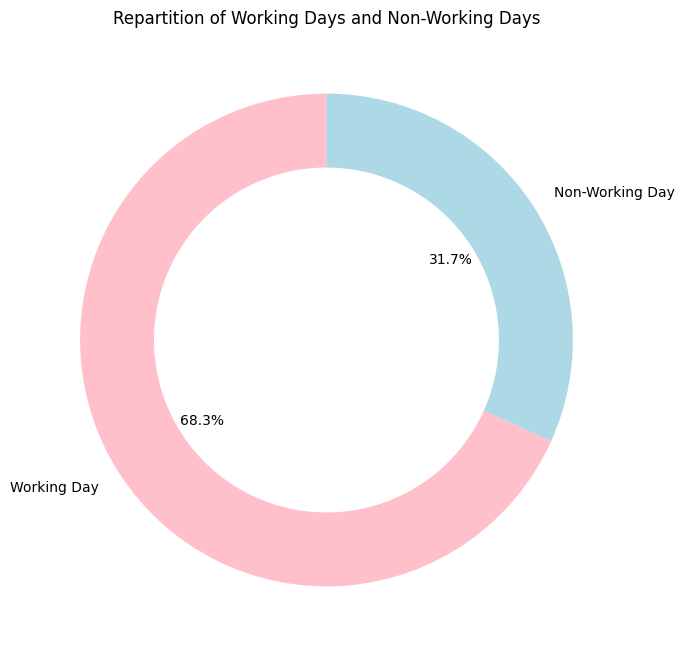

In [24]:
# Count occurrences of working days and non-working days
workingday_counts = data['workingday'].value_counts()

# Define colors
colors = ['pink','lightblue']

# Create a donut chart
plt.figure(figsize=(8, 8))
plt.pie(workingday_counts, labels=['Working Day', 'Non-Working Day'], autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3), colors=colors)
plt.title('Repartition of Working Days and Non-Working Days')

# Draw a circle at the center to create a donut chart
centre_circle = plt.Circle((0, 0), 0.6, color='white', fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Show the plot
plt.show()


Using the previous two donut charts we can see that, non-working days represent quite a large chunk of total days. However, comparing them, we are surprised to see that the ratio is very 1 to 1.. Indeed, people are not particularly more inclined to go bike-riding than when it is a working day. We could therefore recommend our customer to create some promotional events for users to motivate them to rent more bikes on week-ends and national holidays or bank holidays.

In [25]:
# UPDATE HERE

# Group by 'workingday' and sum the counts
workingday_counts = data.groupby('workingday')['cnt'].sum().reset_index()

# Define labels, sizes, and colors for the pie chart
labels = ['Non-Working Day', 'Working Day']
sizes = workingday_counts['cnt']
colors = ['lightblue', 'pink']

# Create the pie chart using Plotly Express
fig = go.Figure(data=[go.Pie(labels=labels, values=sizes, hole=0.3, textinfo='percent', marker=dict(colors=colors))])

# Set layout options
fig.update_layout(title='Repartition of Counts between Working Days and Non-Working Days')

# Show the chart
fig.show()

In [28]:
# UPDATE HERE

# Count occurrences of working days and non-working days
workingday_counts = data['workingday'].value_counts()

# Define labels, sizes, and colors for the pie chart
labels = ['Working Day', 'Non-Working Day']
sizes = workingday_counts.values
colors = ['lightblue', 'pink']

# Create the pie chart using Plotly Express
fig = go.Figure(data=[go.Pie(labels=labels, values=sizes, hole=0.3, textinfo='percent', marker=dict(colors=colors))])

# Set layout options
fig.update_layout(title='Repartition of Working Days and Non-Working Days')

# Show the chart
fig.show()

In [31]:
# Exclude non-numeric columns from the correlation matrix 
# we are excluding the dateday column 
numeric_data = data.select_dtypes(include=[np.number])
correlation = numeric_data.corr().abs()

# Reverse the order of rows and columns
correlation = correlation.iloc[::-1, ::-1]

# Create a heatmap with reversed diagonal values
fig = ff.create_annotated_heatmap(
    z=correlation.values,  # Use the corrected correlation matrix
    x=list(correlation.columns),
    y=list(correlation.index),
    annotation_text=correlation.values.round(2).astype(str),  # Use original values for annotations
    showscale=True,
    colorscale='Blues'
)

# Update layout to make it more readable
fig.update_layout(
    title={
        'text': 'Diagonal Correlation Matrix',  # Update title
        'y': 0.9,  # Adjust title position
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    title_font=dict(size=24, family='Verdana'),
    xaxis=dict(tickangle=45, side='top', automargin=True),  # Rotate x-axis labels and enable auto margin
    yaxis=dict(tickmode='array', automargin=True),
    autosize=False,  # Disable autosize to set custom width and height
    width=1200,  # Increase width if needed
    height=1200,  # Increase height if needed
    margin=dict(l=150, r=150, b=100, t=235),  # Adjust margins to fit labels, increase top margin
)

# Show the corrected diagonal figure
fig.show()

**As we can see, "temp" and "atemp" are highly correlated, so we want to remove one to make sure it doesn't impact the performance of our model. We will keep "atemp" rather than the other, because we believe that more people impulsively decide to rent a bike or not.. in the sense that the decision to ride a bike depends mostly on how each person feels with regard to weather/temperature on instant t (as opposed to deciding very much in advance after checking the real formal temperature online or with a thermometer)**.

Now, recreate for Streamlit.

In [41]:
# Exclude non-numeric columns from the correlation matrix
numeric_data = data.select_dtypes(include=[np.number])
correlation = numeric_data.corr().abs()

# Reverse the order of rows and columns
correlation = correlation.iloc[::-1, ::-1]

# Create a heatmap with reversed diagonal values
fig = go.Figure(data=go.Heatmap(
    z=correlation.values,  # Use the corrected correlation matrix
    x=list(correlation.columns),
    y=list(correlation.index),
    text=correlation.values.round(2).astype(str),  # Use original values for annotations
    hoverinfo='text',
    colorscale='viridis'
))

# Update layout to make it more readable
fig.update_layout(
    title='Correlation Matrix',  # Update title
    xaxis=dict(tickangle=45, side='top', automargin=True),  # Rotate x-axis labels and enable auto margin
    yaxis=dict(tickmode='array', automargin=True),
    autosize=False,  # Disable autosize to set custom width and height
    width=800, 
    height=800, 
    margin=dict(l=150, r=150, b=100, t=235)  # Adjust margins to fit labels, increase top margin
)

# Show the corrected diagonal figure
fig.show()


In [ ]:
# Then, drop 'temp' from the data
data = data.drop(["temp"],axis=1)

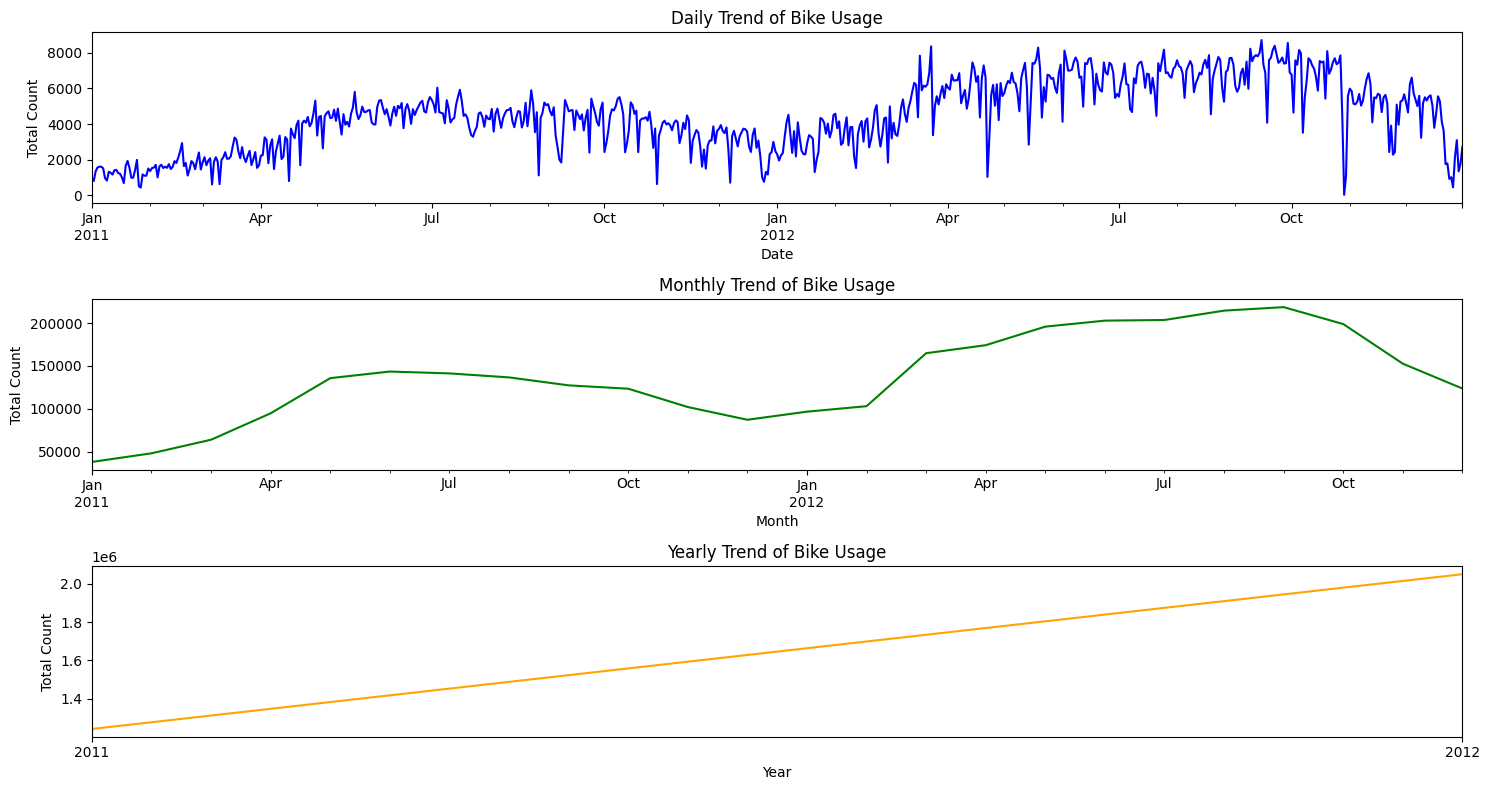

In [31]:
# UPDATE HERE - delete?

# Convert 'dteday' to datetime format
data['dteday'] = pd.to_datetime(data['dteday'])

# Group data by day, month, and year and sum the counts
daily_counts = data.groupby('dteday')['cnt'].sum()
monthly_counts = data.groupby(data['dteday'].dt.to_period("M"))['cnt'].sum()
yearly_counts = data.groupby(data['dteday'].dt.to_period("Y"))['cnt'].sum()

# Plot the line plot for daily, monthly, and yearly trends
plt.figure(figsize=(15, 8))

# Daily Trend
plt.subplot(3, 1, 1)
daily_counts.plot(title='Daily Trend of Bike Usage', ylabel='Total Count', xlabel='Date', color='blue')

# Monthly Trend
plt.subplot(3, 1, 2)
monthly_counts.plot(title='Monthly Trend of Bike Usage', ylabel='Total Count', xlabel='Month', color='green')

# Yearly Trend
plt.subplot(3, 1, 3)
yearly_counts.plot(title='Yearly Trend of Bike Usage', ylabel='Total Count', xlabel='Year', color='orange')

plt.tight_layout()
plt.show()


**We can see that the bike service has become increasingly popular from 2011 to 2012, during the two years observed.
These line plots give a more clear indication of the variation of bike usage during the year and months.**

In [32]:
# UPDATE HERE - delete?

import pandas as pd
import plotly.express as px

# Convert 'dteday' to datetime format
data['dteday'] = pd.to_datetime(data['dteday'])

# Group data by day, month, and year and sum the counts
daily_counts = data.groupby('dteday')['cnt'].sum()
monthly_counts = data.groupby(data['dteday'].dt.to_period("M"))['cnt'].sum()
yearly_counts = data.groupby(data['dteday'].dt.to_period("Y"))['cnt'].sum()

# Plot the line plot for daily, monthly, and yearly trends
fig = px.line(title='Trend of Bike Usage Over Time')
fig.add_scatter(x=daily_counts.index, y=daily_counts.values, mode='lines', name='Daily', line=dict(color='blue'))
fig.add_scatter(x=monthly_counts.index.to_timestamp(), y=monthly_counts.values, mode='lines', name='Monthly', line=dict(color='green'))
fig.add_scatter(x=yearly_counts.index.to_timestamp(), y=yearly_counts.values, mode='lines', name='Yearly', line=dict(color='orange'))

fig.update_xaxes(title='Date')
fig.update_yaxes(title='Total Count')

fig.show()


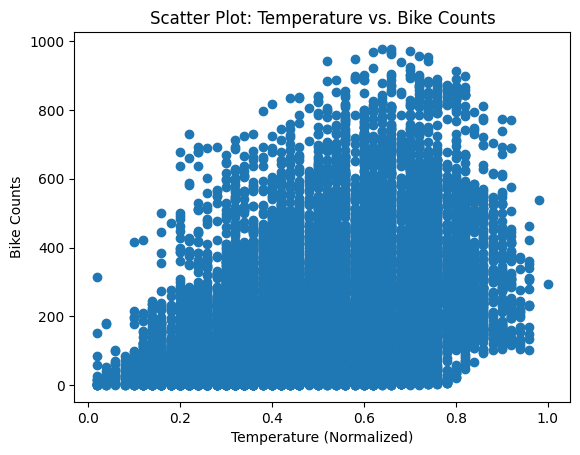

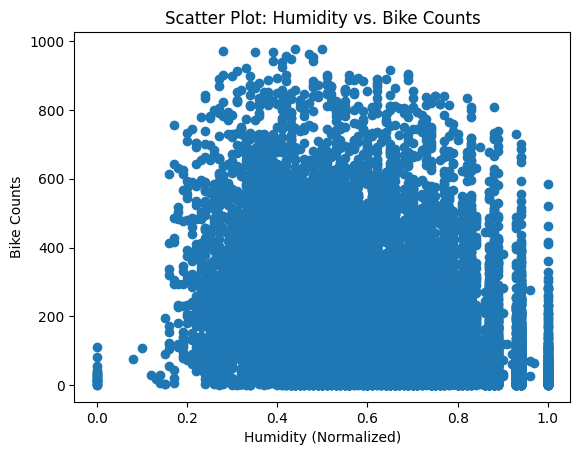

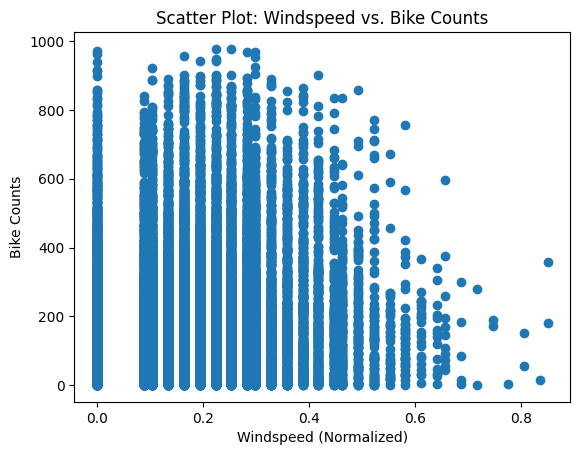

In [33]:
# UPDATE HERE - either delete or add commentary

# Scatter plot for temperature vs. bike counts
plt.scatter(data['temp'], data['cnt'])
plt.xlabel('Temperature (Normalized)')
plt.ylabel('Bike Counts')
plt.title('Scatter Plot: Temperature vs. Bike Counts')
plt.show()

# Scatter plot for humidity vs. bike counts
plt.scatter(data['hum'], data['cnt'])
plt.xlabel('Humidity (Normalized)')
plt.ylabel('Bike Counts')
plt.title('Scatter Plot: Humidity vs. Bike Counts')
plt.show()

# Scatter plot for windspeed vs. bike counts
plt.scatter(data['windspeed'], data['cnt'])
plt.xlabel('Windspeed (Normalized)')
plt.ylabel('Bike Counts')
plt.title('Scatter Plot: Windspeed vs. Bike Counts')
plt.show()

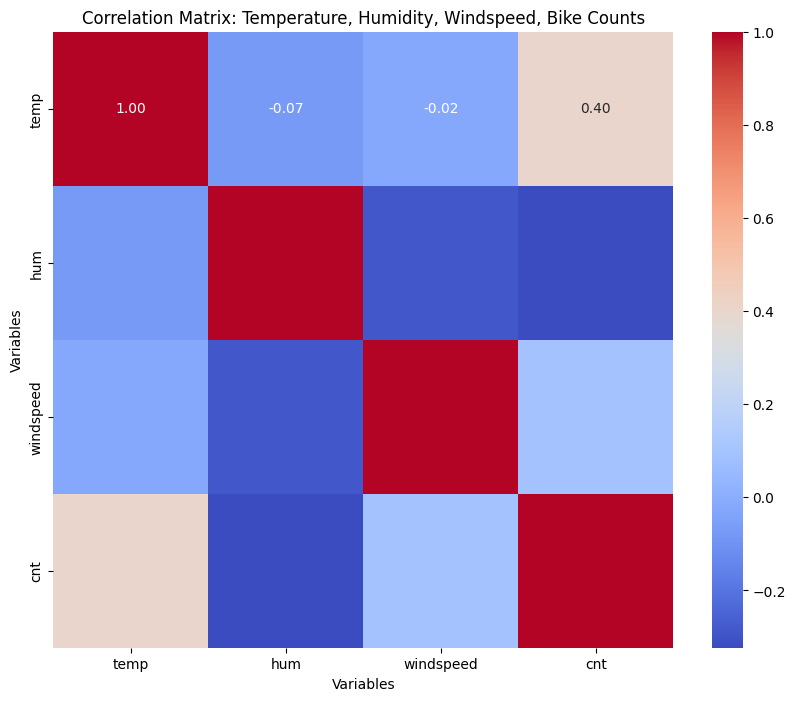

In [34]:
# Calculate correlation matrix
correlation_matrix = data[['temp', 'hum', 'windspeed', 'cnt']].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Temperature, Humidity, Windspeed, Bike Counts')
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.show()

Same, in plotly express.

In [35]:
# Calculate correlation matrix
correlation_matrix = data[['temp', 'hum', 'windspeed', 'cnt']].corr()

# Convert correlation matrix to DataFrame
correlation_df = correlation_matrix.reset_index().melt(id_vars='index')

# Create the heatmap with Plotly Express
fig = px.imshow(correlation_df.pivot(index='index', columns='variable', values='value'),
                labels=dict(index="Variables", variable="Variables", color="Correlation"),
                x=correlation_matrix.columns,
                y=correlation_matrix.index,
                color_continuous_scale='Viridis',  # Use a valid colorscale
                zmin=-1, zmax=1)

# Update layout
fig.update_layout(title='Correlation Matrix: Temperature, Humidity, Windspeed, Bike Counts')

# Show the plot
fig.show()

**Here we are plotting a heatmap combining these metrics to see how all these different meterological conditions affect each other and the total count.**

**We can observe some logical correlations, like for example the negative correlation between temperature and humidity, or the positive correlation between temperature and total count. However, there are some interesting ones, like for example the fact that windspeed is very weakly correlated with count.. showing that is the least important factor in deciding weather or not to ride a bike. In that case, we could recommend the customer to implement/build something on the bikes to resist more against other meterological factors (like humidity for example), rather than wind.**

In [36]:
# UPDATE HERE - to delete?
# Calculate correlation matrix
correlation_matrix = data[['temp', 'hum', 'windspeed', 'cnt']].corr()

# Create an interactive heatmap with Plotly Express
fig = px.imshow(correlation_matrix,
                labels=dict(x="Variables", y="Variables", color="Correlation"),
                x=correlation_matrix.columns,
                y=correlation_matrix.columns,
                color_continuous_scale='RdBu',
                zmin=-1, zmax=1)

fig.update_layout(title='Correlation Matrix: Temperature, Humidity, Windspeed, Bike Counts')

# Show the interactive plot
fig.show()

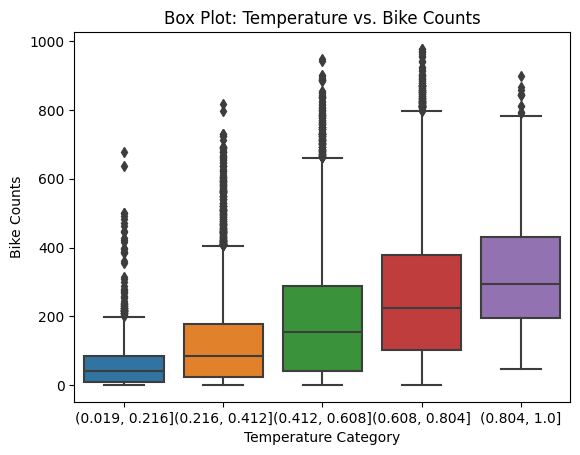

In [42]:
# Box plot for temperature categories
data['temp_category'] = pd.cut(data['temp'], bins=5)
sns.boxplot(x='temp_category', y='cnt', data=data)
plt.xlabel('Temperature Category')
plt.ylabel('Bike Counts')
plt.title('Box Plot: Temperature vs. Bike Counts')
plt.show()

This graph doesn't add much from before as it mostly just confirms that the median bike count increases as temperature rises, suggesting a positive correlation between temperature and bike usage.. However, there are two points that are worth noting:

**The whiskers**, which indicate the spread of data between the quartiles and represent the min and max values of bike counts between each temperature range, interestingly have a higher max point for the second to last range. This would indicate that the ideal temperatures to rent bikes would be between ~24.928 and ~32.964 degrees celsius.

**Outliers**: Many of the boxes also have a large number of outliers / extreme values for their temperature range. These might represent unusual or unexpected occurrences in bike counts that deviate significantly from the typical pattern observed within that temperature range. This could also indicate skewness, as the data is not symmetrically distributed around the mean. It would also show high variability and dispersion in the data. Additionally, these numerous outliers may also signify the occurrence of unusual events or factors that influence bike counts in unexpected ways. For example, extreme weather conditions, special events, or holidays may lead to temporary spikes or drops in bike usage, resulting in outlier observations.

In [43]:
# Convert temperature categories to strings
data['temp_category'] = pd.cut(data['temp'], bins=5).astype(str)

# Create the box plot with Plotly Express
fig = px.box(data_frame=data, x='temp_category', y='cnt', 
             labels={'temp_category': 'Temperature Category', 'cnt': 'Bike Counts'},
             title='Box Plot: Temperature vs. Bike Counts')

# Show the plot
fig.show()

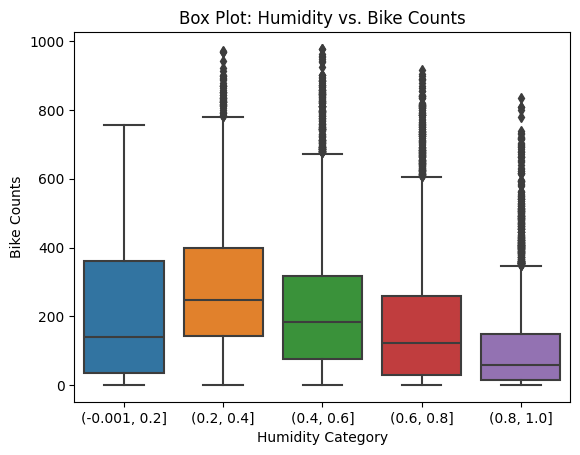

In [44]:
# Box plot for humidity categories
data['hum_category'] = pd.cut(data['hum'], bins=5)
sns.boxplot(x='hum_category', y='cnt', data=data)
plt.xlabel('Humidity Category')
plt.ylabel('Bike Counts')
plt.title('Box Plot: Humidity vs. Bike Counts')
plt.show()

**Here we can observe that the ideal humidity climate to rent bikes would be the second category (0.2, 0.4], as it has the highest median; the highest max bike count; as well as overall good spread of data with few outliers.**

In [45]:
# Convert humidity categories to strings
data['hum_category'] = pd.cut(data['hum'], bins=5).astype(str)

# Create the box plot with Plotly Express
fig = px.box(data_frame=data, x='hum_category', y='cnt', 
             labels={'hum_category': 'Humidity Category', 'cnt': 'Bike Counts'},
             title='Box Plot: Humidity vs. Bike Counts')

# Show the plot
fig.show()

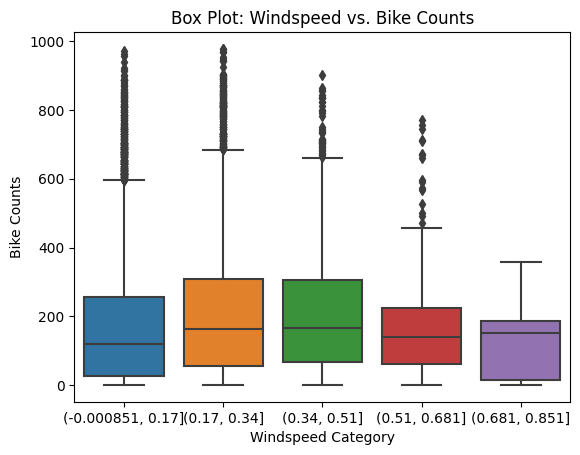

In [46]:
# Create windspeed categories
data['windspeed_category'] = pd.cut(data['windspeed'], bins=5)

# Create a box plot
sns.boxplot(x='windspeed_category', y='cnt', data=data)
plt.xlabel('Windspeed Category')
plt.ylabel('Bike Counts')
plt.title('Box Plot: Windspeed vs. Bike Counts')
plt.show()

In [47]:
# Convert windspeed categories to strings
data['windspeed_category'] = pd.cut(data['windspeed'], bins=5).astype(str)

# Create the box plot with Plotly Express
fig = px.box(data_frame=data, x='windspeed_category', y='cnt', 
             labels={'windspeed_category': 'Windspeed Category', 'cnt': 'Bike Counts'},
             title='Box Plot: Windspeed vs. Bike Counts')

# Show the plot
fig.show()

In [52]:
original_data

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [53]:
# UPDATE HERE - to delete?

# Group data by 'weekday' and sum the counts for casual and registered users
counts_by_day = original_data.groupby('weekday')[['casual', 'registered']].sum().reset_index()

# Melt the dataframe to convert 'casual' and 'registered' into a single column
counts_by_day_melted = counts_by_day.melt(id_vars='weekday', var_name='User Type', value_name='Count')

# Create a line plot using Plotly Express
fig = px.line(counts_by_day_melted, x='weekday', y='Count', color='User Type',
              labels={'weekday': 'Day of the Week', 'Count': 'Count of Rentals', 'User Type': 'User Type'},
              title='Count of Rentals by User Type and Day of the Week')

# Show the plot
fig.show()

In [55]:
# Group data by 'weekday' and sum the counts for casual and registered users
counts_by_day = original_data.groupby('weekday')[['casual', 'registered']].sum().reset_index()

# Calculate total count of rentals for each day
counts_by_day['total'] = counts_by_day['casual'] + counts_by_day['registered']

# Calculate percentage for each user type
counts_by_day['casual_percentage'] = counts_by_day['casual'] / counts_by_day['total'] * 100
counts_by_day['registered_percentage'] = counts_by_day['registered'] / counts_by_day['total'] * 100

# Create a stacked bar chart using Plotly Express
fig = px.bar(counts_by_day, x='weekday', y=['casual_percentage', 'registered_percentage'],
             labels={'weekday': 'Day of the Week', 'value': 'Percentage', 'variable': 'User Type'},
             title='Percentage of Rentals by User Type and Day of the Week',
             color_discrete_map={'casual_percentage': 'lightblue', 'registered_percentage': 'orange'},
             barmode='stack')

# Show the plot
fig.show()

Similar chart in plotly express below.

In [60]:
# Group data by 'weekday' and sum the counts for casual and registered users
weekly_counts = original_data.groupby('weekday')[['casual','registered']].sum().reset_index()

# Format the data properly so we can use it to show percentages in the stacked bar charts
week_reg = original_data.groupby('weekday')[['registered']].sum().reset_index()
week_reg['TYPE'] = 'Registered'
week_reg['user'] = week_reg['registered']
week_reg = week_reg.drop('registered',axis=1)

week_cas = original_data.groupby('weekday')[['casual']].sum().reset_index()
week_cas['TYPE'] = 'Casual'
week_cas['user'] = week_cas['casual']
week_cas = week_cas.drop('casual',axis=1)

# Combine above DFs vertically and add weight column
combine_week = (week_reg,week_cas)
total_week = pd.concat(combine_week)
total_week['weight'] = total_week['user'] / total_week.groupby(['weekday'])['user'].transform('sum')

fig2 = px.bar(total_week, x="weekday", y='weight', color='TYPE',  
            title="Share of Casual and Registered Users by Day of Week",
            labels={'weight': 'Share', 'TYPE': 'Type of User','weekday':'Day of Week'},
            color_discrete_sequence=['rebeccapurple','darkcyan'],
            width=800, height=500)
fig2.update_layout(
        xaxis = dict(
            tickmode = 'array',
            tickvals = [0,1,2,3,4,5,6],
            ticktext = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
            )
        )
fig2.update_traces(texttemplate='%{value:.2f}')

# Show the plot
fig2.show()

This confirms the trend of casuals biking more at the end of the week.

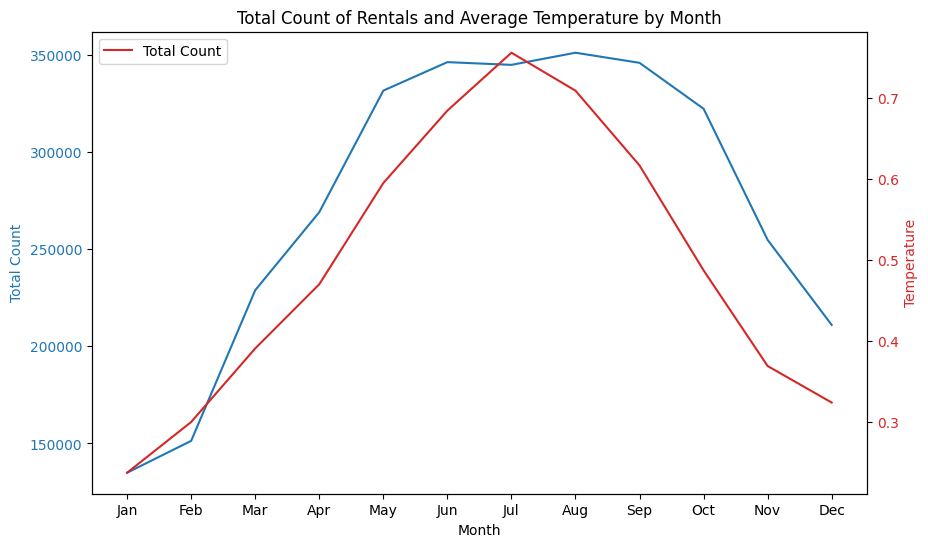

In [61]:
# Group data by month and calculate the total count of rentals and the average temperature
monthly_data = data.groupby('mnth').agg({'cnt': 'sum', 'temp': 'mean'}).reset_index()

# Create a figure and axis object
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total count of rentals on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Count', color=color)
ax1.plot(monthly_data['mnth'], monthly_data['cnt'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for temperature
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Temperature', color=color)
ax2.plot(monthly_data['mnth'], monthly_data['temp'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set x-axis labels
ax1.set_xticks(monthly_data['mnth'])
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Add title and legend
plt.title('Total Count of Rentals and Average Temperature by Month')
plt.legend(['Total Count', 'Temperature'], loc='upper left')

# Show the plot
plt.show()


This was a very interesting chart, but we decided not to include it in the application as we felt we already had charts that portrayed the same information.

In [ ]:
# Save the cleaned data down for use in streamlit
data.to_csv('cleaned_data.csv', index=False)

## PART II: Prediction Model

In [70]:
# Dropped several created fields used for EDA
data = data.drop(["temp_category","hum_category","windspeed_category"], axis=1) 

In [71]:
# Split data into features and target
X = data.drop(["cnt"], axis=1).values 
y = data["cnt"].values

In [73]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [75]:
# Instatiate and fit random forest regressor
random_forest = RandomForestRegressor(random_state=42, max_features='sqrt')  
random_forest.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', random_state=42)

In [ ]:
# GridSearchCV for hyperparameter tuning
param_grid = {'max_depth': range(20,25)}

crossval_rf = GridSearchCV(random_forest, param_grid, scoring='r2', cv=5 , n_jobs=1, verbose=1)

crossval_rf.fit(X_train,y_train);

In [ ]:
print("Best parameters set found on train set:")
print()
print(crossval_rf.best_params_)
print()
print("Grid scores on train set:")
print()
means = crossval_rf.cv_results_['mean_test_score']
stds = crossval_rf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, crossval_rf.cv_results_['params']):
    print("Negative MSE = %0.3f (+/%0.03f) for %r" % (mean, std * 2, params))

In [ ]:
# Visualize the different accuracies for different depths of the decision tree
plt.figure(figsize=(10,10))
plt.errorbar(range(20,25,1), [m for m in means], yerr=stds, fmt='-o')
plt.title('R^2 for Different Depths', fontsize=20)
plt.xlabel("Depth", fontsize=16)
plt.ylabel("R^2", fontsize=16)
plt.show()

In [ ]:
# Save model for future use
best_est = crossval_rf.best_estimator_

joblib.dump(best_est,"Model2.joblib")

In [ ]:
# Save means as well
joblib.dump(means,"means.joblib")

In [ ]:
model = joblib.load("Model2.joblib")
means = joblib.load("means.joblib")

In [ ]:
# Put data together for a DataFrame on R^2 by Max Depth, which will be used in streamlit for a chart
depth = [20,21,22,23,24]
list = list(means)
frame = [[depth[0], list[0]], [depth[1], list[1]], [depth[2], list[2]],[depth[3], list[3]],[depth[4], list[4]]]
df = pd.DataFrame(frame, columns=['Max_Depth','R2'])

In [ ]:
fig3 = px.line(df, 
            x='Max_Depth', 
            y='R2', 
            labels={"Max_Depth": 'Max Depth', "R2": 'R^2'},
            title='R^2 by Different Max Depths')
fig3

In [ ]:
# R2 for test set is slightly worse than for train set
print("R^2: Train = {0:.4f}".format(np.mean(cross_val_score(model, X_train, y_train, scoring='r2'))))
print("R^2: Test = {0:.4f}".format(np.mean(cross_val_score(model, X_test, y_test, scoring='r2'))))

In [ ]:
# Plot feature importances for the random forest
drop_data = data.drop(["cnt"],axis=1)
plt.figure(figsize=(10,10))
plt.bar(drop_data.columns, model.feature_importances_)
plt.xticks(rotation=60)
plt.title('Feature Importance', fontsize=16)
plt.show()

In [ ]:
fig = px.bar(model.feature_importances_, 
            x=model.feature_importances_, 
            y=drop_data.columns, 
            labels={"cnt": 'Count of Rentals',"weathersit": 'Weather Type'},
            title='Count of Rentals by Weather',
            barmode='group')
fig

## PART III: Streamlit dashboard

In [49]:
### This part goes in a separate script ###